In [11]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Dataset

In [383]:

psi = [
    0, 0.002, 0.0356, 0.0991, 0.1662, 0.2297, 0.2852, 0.3299, 0.3631, 0.3861, 0.4012, 0.4107, 0.4163, 0.4192, 0.4203, 0.4200,
    0.4188, 0.4170, 0.4147, 0.4122, 0.4095, 0.4069, 0.4042, 0.4017, 0.3993, 0.3971, 0.3951, 0.3932, 0.3916, 0.3900,
    0.3886, 0.3874, 0.3863, 0.3853, 0.3844, 0.3836, 0.3828, 0.3822, 0.3816, 0.3810, 0.3806, 0.3801, 0.3798, 0.3794,
    0.3791, 0.3788, 0.3786, 0.3783, 0.3781, 0.3780, 0.3778, 0.3776, 0.3775, 0.3774, 0.3773, 0.3772, 0.3771, 0.3770,
    0.3769, 0.3769, 0.3768, 0.3768, 0.3767, 0.3767, 0.3766, 0.3766, 0.3766, 0.3766, 0.3765, 0.3765, 0.3765, 0.3765,
    0.3764, 0.3764, 0.3764, 0.3764, 0.3764, 0.3764, 0.3764, 0.3764, 0.3764, 0.3764, 0.3763, 0.3763, 0.3763, 0.3763,
    0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763,
    0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763, 0.3763,
    0.3763, 0.3763, 0.3763, 0.3763
]

start = 0
step = 0.25
n = len(psi)  # Number of elements

# Generate the array
t = np.arange(start, start + n * step, step)

v = 1
dt = 0.25

# Step 1: Integrate psi to get yaw rate
yaw_rate = np.cumsum(psi) * dt

# Step 3: Calculate X and Y displacements using yaw angle (theta)
x = np.zeros(len(t))
y = np.zeros(len(t))

for i in range(1, len(t)):
    dx = v * np.cos(yaw_rate[i]) * dt
    dy = v * np.sin(yaw_rate[i]) * dt
    x[i] = x[i - 1] + dx
    y[i] = y[i - 1] + dy


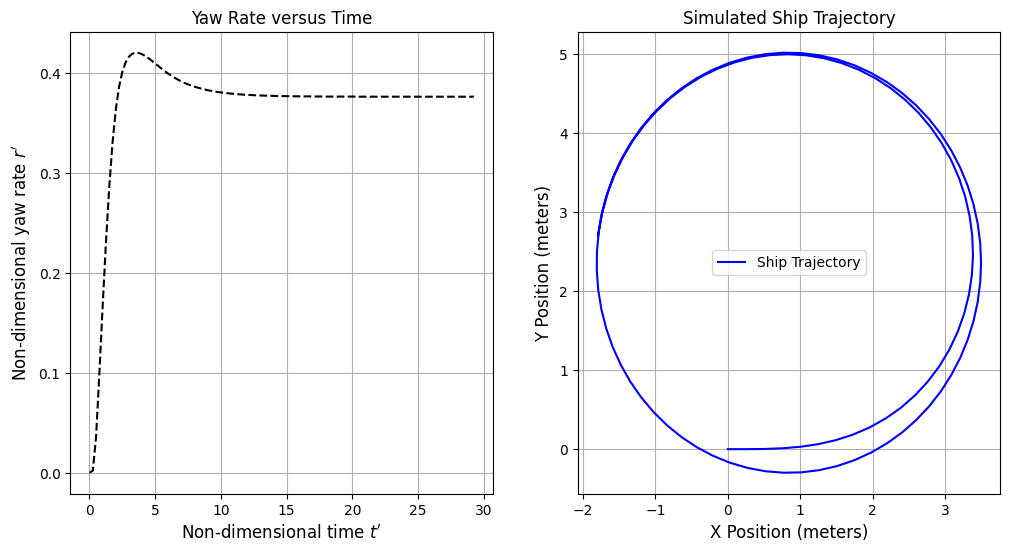

In [384]:
# Plot the yaw rate versus time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, psi, 'k--')
plt.title('Yaw Rate versus Time')
plt.xlabel('Non-dimensional time $t\'$', fontsize=12)
plt.ylabel('Non-dimensional yaw rate $r\'$', fontsize=12)
plt.grid()

# Plot the ship's trajectory
plt.subplot(1, 2, 2)
plt.plot(x, y, 'b-', label='Ship Trajectory')
plt.xlabel('X Position (meters)', fontsize=12)
plt.ylabel('Y Position (meters)', fontsize=12)
plt.title('Simulated Ship Trajectory')
plt.legend()
plt.grid()
plt.show()

# Optimisation Parameters

In [345]:
import numpy as np
from scipy.integrate import solve_ivp

def Simulate(K, T):

    # Define the ODE function based on the provided MATLAB function 'nomoto_ode1'
    def nomoto_ode1(t, v, params):
        T = params['T']  # Non-dimensional Nomoto Time Constant
        K = params['K']  # Non-dimensional Nomoto Gain

        rp = v  # Non-dimensional yaw rate
        delta = 35 * np.pi / 180# Rudder angle in radians
        
        vd = K * delta * np.exp(-t / T) / T  # Non-dimensional time derivative of yaw rate
        return vd

    # Assuming data.tp, data.rp, and data.delta are provided as NumPy arrays
    tp = t  # Non-dimensional time t'
    delta = 35  # Rudder angle delta

    # Define parameters in a dictionary (equivalent to MATLAB struct)
    params = {
        'T': T,
        'K': K
    }

    # Solve the ODE using solve_ivp
    sol1 = solve_ivp(lambda t, v: nomoto_ode1(t, v, params), [0, tp[-1]], [0], t_eval=tp)

    # Extract the solution for the yaw rate
    rp_nomoto1 = sol1.y[0]  # Extract the first (and only) row for the yaw rate

    # Step 1: Compute the yaw angle (psi) by integrating the yaw rate
    # psi2 = np.cumsum(rp_nomoto1) * (dt)  # Integrating yaw rate to get yaw angle

    psi_namoto1 = np.cumsum(rp_nomoto1) * (dt)

    # Step 2: Calculate x and y positions based on yaw angle
    v = 1  # Ship speed (m/s)

    # Initialize x and y positions
    x_namoto = np.zeros(len(t))
    y_namoto = np.zeros(len(t))

    # Calculate x and y positions based on yaw angle and speed
    for i in range(1, len(t)):
        x_namoto[i] = x_namoto[i-1] + v * np.cos(psi_namoto1[i]) * (dt)
        y_namoto[i] = y_namoto[i-1] + v * np.sin(psi_namoto1[i]) * (dt)
    
    return (rp_nomoto1, x_namoto, y_namoto)


In [362]:
def ObjectiveFunc(params):
    K, T = params
    p_rp, p_x, p_y = Simulate(K, T)
    error = np.sqrt( sum(p_rp - psi)**2)
    return error

In [367]:
from scipy.optimize import minimize
bounds = [(0.05, 1), (0.5, 50)]
# Initial guess
initial_guess = [0.61, 0.5]

# Perform the optimization
result = minimize(ObjectiveFunc, initial_guess, bounds=bounds)

# Print the result
print("Optimal K:", result.x[0])
print("Optimal T:", result.x[1])
print("Minimum error:", result.fun)

Optimal K: 0.6134482738584941
Optimal T: 0.5000000000001528
Minimum error: 3.341086093344714e-07


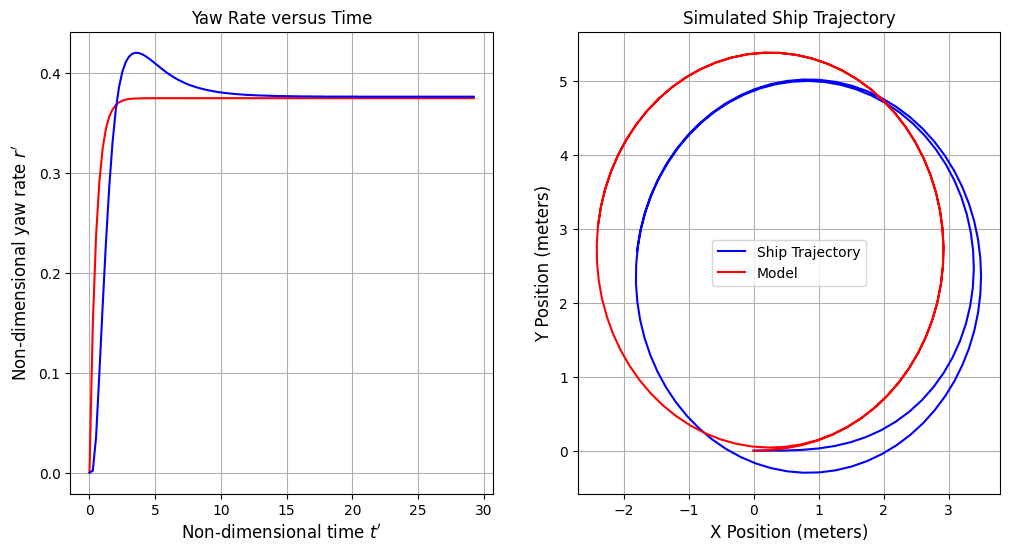

In [368]:
check = Simulate(result.x[0], result.x[1])
# Plot the yaw rate versus time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, check[0], 'r-')
plt.plot(t, psi, 'b-', label='Yaw Rate (Data)')
plt.title('Yaw Rate versus Time')
plt.xlabel('Non-dimensional time $t\'$', fontsize=12)
plt.ylabel('Non-dimensional yaw rate $r\'$', fontsize=12)
plt.grid()

# Plot the ship's trajectory
plt.subplot(1, 2, 2)
plt.plot(x, y, 'b-', label='Ship Trajectory')
plt.plot(check[1], check[2], "r-", label = "Model")
plt.xlabel('X Position (meters)', fontsize=12)
plt.ylabel('Y Position (meters)', fontsize=12)
plt.title('Simulated Ship Trajectory')
plt.legend()
plt.grid()
plt.show()

# Surrogate Creation

In [ ]:
# sampling

from pyDOE import lhs

# Number of samples
n_samples = 15

# Define ranges for K and T
range_K = [0.05, 1.5]
range_T = [0.5, 2]

# Generate LHS samples
lhs_samples = lhs(2, samples=n_samples)

# Scale the samples to the desired ranges
K_samples = range_K[0] + (range_K[1] - range_K[0]) * lhs_samples[:, 0]
T_samples = range_T[0] + (range_T[1] - range_T[0]) * lhs_samples[:, 1]

# Combine K and T samples into one matrix
# samples = np.column_stack((K_samples, T_samples))

# Display the samples
print('LHS samples for K and T:')
print(K_samples, T_samples)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(K_samples, T_samples, c='blue', marker='o', edgecolor='black')
plt.title('LHS Samples for K and T')
plt.xlabel('K')
plt.ylabel('T')
plt.grid(True)

for i in range(n_samples):
    plt.annotate(f"({K_samples[i]:.2f}, {T_samples[i]:.2f})", 
                 (K_samples[i], T_samples[i]), 
                 textcoords="offset points", 
                 xytext=(5, 5),  # Offset the text a bit from the point
                 ha='center', fontsize=9, color='black')
# Show plot
plt.show()

In [370]:
_k = [1.07464898, 0.059159, 0.97203122, 0.40437054, 0.17746028, 1.4060953, 1.14744637, 0.26096514, 0.70128401, 1.22624208, 0.44408525, 1.32043614, 0.72878661, 0.62199122, 0.88938971] 
_t = [0.91601047, 1.4337127,  1.0323762,  0.67529828, 1.14645313, 1.7181541, 0.51642231, 0.74885158, 0.80954722, 1.60969235, 1.34012712, 1.98626857, 1.52167112, 1.25721942, 1.83057144]
y = [ObjectiveFunc([_kbar, _tbar]) for _kbar, _tbar in zip(_k, _t)]

In [374]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


X = np.column_stack((_k, _t))

# Create a polynomial features object with degree 2 (change as needed)
poly = PolynomialFeatures(degree=3)

# Create a polynomial regression model pipeline
model = make_pipeline(poly, LinearRegression())

# Fit the model
model.fit(X, y)

# Predict using the model
predictions = model.predict(X)

print("Coefficients:", model.named_steps['linearregression'].coef_)
print("Intercept:", model.named_steps['linearregression'].intercept_)
print("Predictions:", predictions)

Coefficients: [   0.         -289.74908146   53.21867932  235.65304362  114.25712859
  -82.00420113  -24.19129951  -60.14560552  -13.185518     25.85154425]
Intercept: 64.5482723264926
Actual: [np.float64(31.453376587576674), np.float64(39.2336357658817), np.float64(24.043145361579906), np.float64(14.918995002884946), np.float64(31.03237210720377), np.float64(51.754833805141715), np.float64(37.6232093750954), np.float64(25.02075982747725), np.float64(5.672296511187332), np.float64(39.92420130226613), np.float64(12.851144093469836), np.float64(45.102143112896655), np.float64(6.3296689101545995), np.float64(0.538298005637689), np.float64(16.59064978065614)]
Predictions: [32.06339607 39.93611518 21.65614044 12.94648866 30.59837343 53.25891182
 37.74653631 26.60696482  6.81851333 38.04753845  8.08019051 44.57556735
  7.21652491  5.4662795  17.07118875]


In [379]:
import pandas as pd
df = pd.DataFrame({
    'K': _k,
    'T': _t,
    'J(K, T)': y,
    "Y(K, T)": predictions
})
print(df)

           K         T    J(K, T)    Y(K, T)
0   1.074649  0.916010  31.453377  32.063396
1   0.059159  1.433713  39.233636  39.936115
2   0.972031  1.032376  24.043145  21.656140
3   0.404371  0.675298  14.918995  12.946489
4   0.177460  1.146453  31.032372  30.598373
5   1.406095  1.718154  51.754834  53.258912
6   1.147446  0.516422  37.623209  37.746536
7   0.260965  0.748852  25.020760  26.606965
8   0.701284  0.809547   5.672297   6.818513
9   1.226242  1.609692  39.924201  38.047538
10  0.444085  1.340127  12.851144   8.080191
11  1.320436  1.986269  45.102143  44.575567
12  0.728787  1.521671   6.329669   7.216525
13  0.621991  1.257219   0.538298   5.466280
14  0.889390  1.830571  16.590650  17.071189


In [381]:
# Define the surrogate function
def surrogate_function(v):
    v1, v2 = v
    X_new = np.array([[v1, v2]])
    return model.predict(X_new)[0]

# Optimize the surrogate function
resultSurr = minimize(surrogate_function, x0=initial_guess, bounds=bounds)
optimal_v = resultSurr.x
optimal_value = resultSurr.fun

print("Optimal values (v1, v2):", optimal_v)
print("Minimum value of the surrogate function:", optimal_value)

Optimal values (v1, v2): [0.64787062 0.5       ]
Minimum value of the surrogate function: 0.7554193222171648


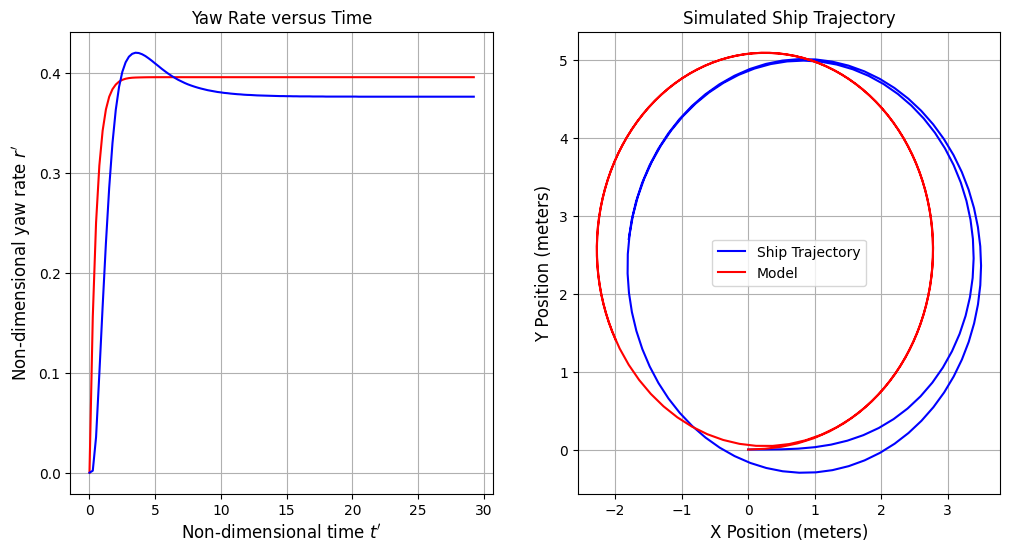

In [385]:
checkSurr = Simulate(resultSurr.x[0], resultSurr.x[1])
# Plot the yaw rate versus time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, checkSurr[0], 'r-')
plt.plot(t, psi, 'b-', label='Yaw Rate (Data)')
plt.title('Yaw Rate versus Time')
plt.xlabel('Non-dimensional time $t\'$', fontsize=12)
plt.ylabel('Non-dimensional yaw rate $r\'$', fontsize=12)
plt.grid()

# Plot the ship's trajectory
plt.subplot(1, 2, 2)
plt.plot(x, y, 'b-', label='Ship Trajectory')
plt.plot(checkSurr[1], checkSurr[2], "r-", label = "Model")
plt.xlabel('X Position (meters)', fontsize=12)
plt.ylabel('Y Position (meters)', fontsize=12)
plt.title('Simulated Ship Trajectory')
plt.legend()
plt.grid()
plt.show()